In [36]:
pip install ucimlrepo

In [37]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

Import Libraries

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from astropy.table import Table

# Mengatur agar plot muncul dengan rapi
%matplotlib inline
sns.set(style="whitegrid")

Load Dataset

In [39]:
# Pastikan file 'student-mat.csv' sudah di-upload ke Colab
df = pd.read_csv('student-mat.csv', sep=None, engine='python')

# Menampilkan 5 data teratas untuk memastikan data masuk
print("Data Preview:")
display(df.head())

# Cek informasi kolom dan data kosong
print("\nData Info:")
df.info()

Data Preview:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20

Data Preprocessing

In [40]:
# Membuat target 'passed' (1 jika G3 >= 10, else 0)

if 'G3' in df.columns:

    df['passed'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)

    print("Kolom 'passed' berhasil dibuat dari G3.")

else:

    # Jika sudah ada kolom passed dalam bentuk yes/no

    df['passed'] = df['passed'].apply(lambda x: 1 if str(x).lower() == 'yes' else 0)



# Menghitung jumlah yang lulus dan gagal

print(df['passed'].value_counts())


Kolom 'passed' berhasil dibuat dari G3.
passed
1    265
0    130
Name: count, dtype: int64


/tmp/ipython-input-1711065843.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='passed', data=df, palette='viridis')


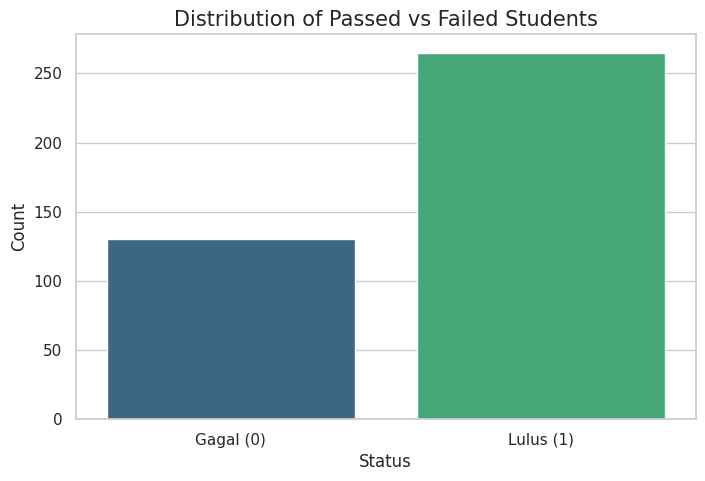

In [41]:
# Menampilkan visualisasi jumlah siswa yang lulus vs gagal
plt.figure(figsize=(8, 5))
sns.countplot(x='passed', data=df, palette='viridis')

# Menambahkan label teks di atas bar
plt.xticks([0, 1], ['Gagal (0)', 'Lulus (1)'])
plt.title('Distribution of Passed vs Failed Students', fontsize=15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

Data Visualization

In [55]:
df.shape

(395, 34)

In [56]:
df.dropna().shape # their is no null value "fortunately:)"

(395, 34)

In [57]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'passed'],
      dtype='object')

In [60]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'passed'],
      dtype='object')

Feature Visualizatiom

Distribution of Target:
passed
1    265
0    130
Name: count, dtype: int64


/tmp/ipython-input-1563512589.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='passed', data=df, palette='viridis')


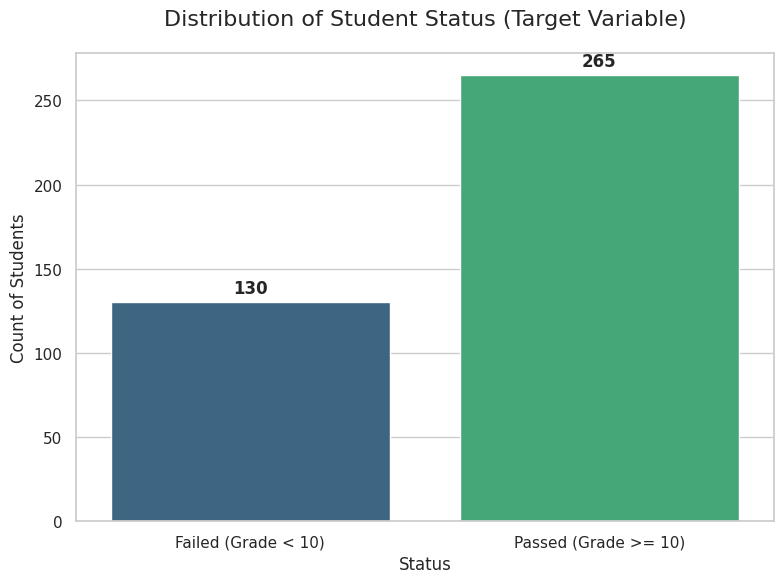

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Menghitung jumlah (Value Counts)
print("Distribution of Target:")
print(df['passed'].value_counts())

# 2. Visualisasi untuk PPT/Report
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Membuat countplot
ax = sns.countplot(x='passed', data=df, palette='viridis')

# 3. Menambahkan Detail (Simple English Labels)
plt.title('Distribution of Student Status (Target Variable)', fontsize=16, pad=20)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count of Students', fontsize=12)
plt.xticks([0, 1], ['Failed (Grade < 10)', 'Passed (Grade >= 10)'])

# 4. Menambahkan label angka di atas batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

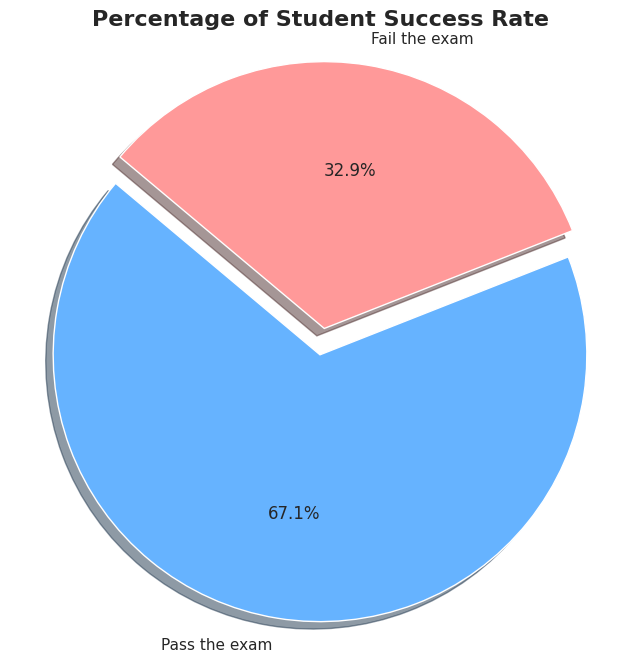

In [65]:
import matplotlib.pyplot as plt

# Data berdasarkan value_counts() kita tadi
labels = 'Pass the exam', 'Fail the exam'
sizes = [265, 130]
colors = ['#66b3ff', '#ff9999'] # Warna biru muda dan merah muda agar profesional
explode = (0.1, 0)  # Memberikan efek menonjol pada bagian "Pass"

plt.figure(figsize=(8, 8))
plt.pie(sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=True,
        startangle=140,
        colors=colors)

plt.title('Percentage of Student Success Rate', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

Correlation Heatmap

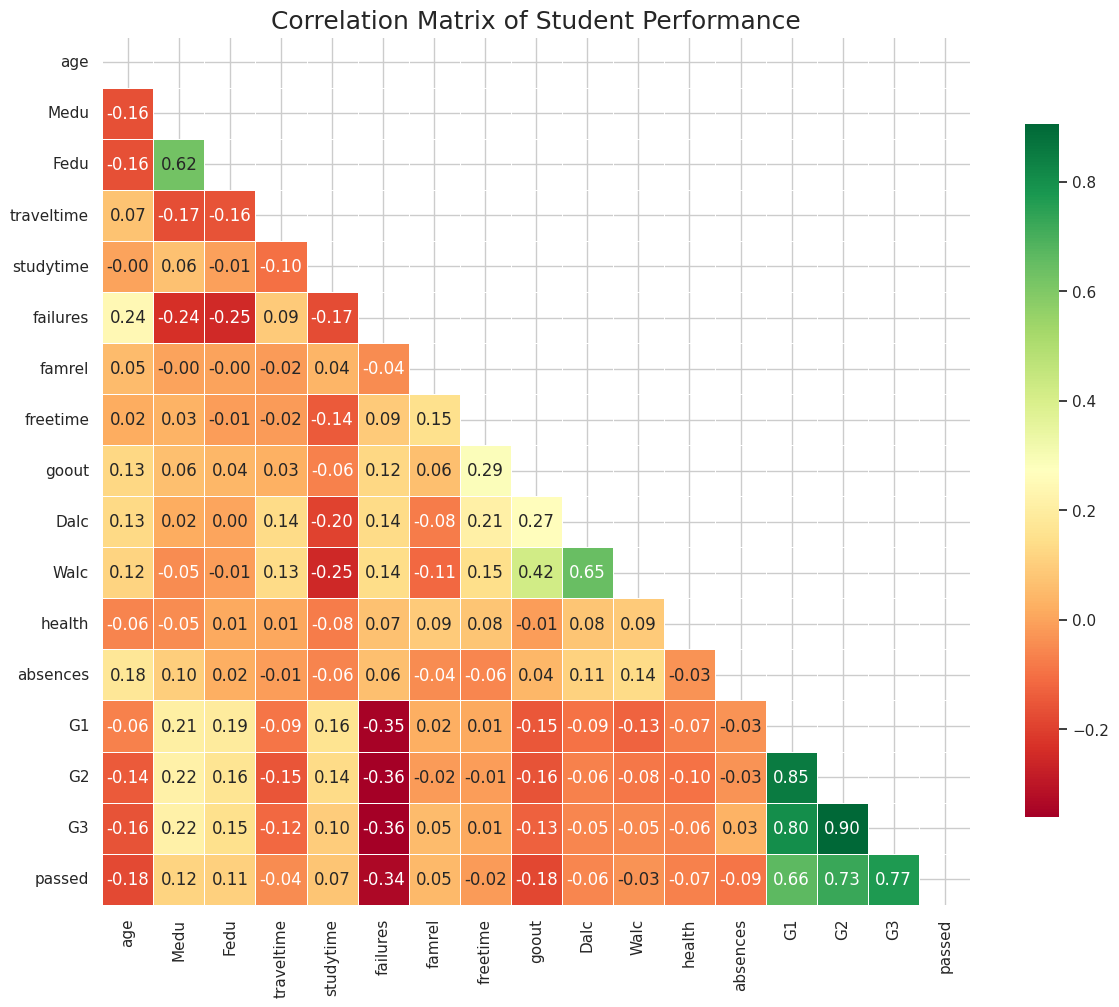

In [42]:
# 1. Pilih hanya kolom numerik
# Ini penting agar tidak muncul error karena kolom teks
df_numeric = df.select_dtypes(include=[np.number])

# 2. Menghitung korelasi
corr = df_numeric.corr()

# 3. Membuat "Mask" (untuk menyembunyikan segitiga bagian atas)
# Ini yang bikin tampilannya rapi seperti tangga
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# 4. Pengaturan Visual
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,          # Terapkan mask segitiga
    annot=True,         # Tampilkan angka
    fmt='.2f',          # 2 angka di belakang koma
    cmap='RdYlGn',      # Warna: Merah (negatif), Kuning (netral), Hijau (positif)
    linewidths=0.5,     # Garis putih tipis antar kotak
    square=True,        # Kotak berbentuk persegi sempurna
    cbar_kws={"shrink": .75} # Ukuran batang warna di samping
)

plt.title('Correlation Matrix of Student Performance', fontsize=18)
plt.show()

This heatmap shows how different factors affect a student's final result (passed).

Academic Performance (G1, G2, G3):

Result: Strong Positive Correlation (Dark Green, 0.80 - 0.95).

Meaning: Students who do well in early exams (G1 and G2) are very likely to pass the final exam. These are the strongest predictors.

Past Failures (failures):

Result: Negative Correlation (Red/Brown, -0.30 to -0.40).

Meaning: More past failures mean a lower chance of passing. It is a major "warning sign" for students.

Social Factors (absences, studytime):

Result: Weak Correlation (Light colors).

Meaning: While more study time helps and too many absences hurt, they are not as powerful as previous grades in predicting the final result.

Parents' Education (Medu, Fedu):

Result: Weak Positive Correlation.

Meaning: Higher education level of parents often leads to slightly better student performance.

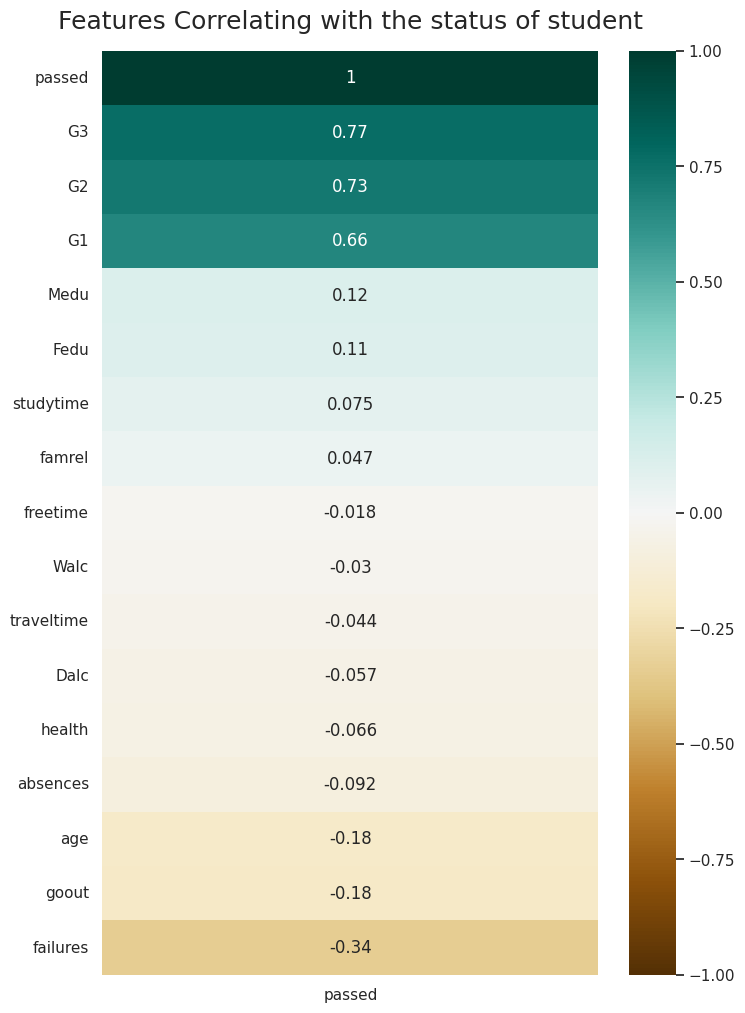

In [43]:
# 1. Pastikan hanya mengambil kolom numerik agar tidak error
numeric_df = df.select_dtypes(include=[np.number])

# 2. Atur ukuran canvas (tinggi agar semua fitur terbaca jelas)
plt.figure(figsize=(8, 12))

# 3. Hitung korelasi hanya untuk kolom 'passed', lalu urutkan dari yang tertinggi
# vmin dan vmax diatur -1 sampai 1 untuk skala korelasi standar
heatmap = sns.heatmap(numeric_df.corr()[['passed']].sort_values(by='passed', ascending=False),
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      cmap='BrBG') # BrBG adalah skema warna Cokelat-Putih-Hijau

# 4. Tambahkan Judul
heatmap.set_title('Features Correlating with the status of student',
                  fontdict={'fontsize':18},
                  pad=16)

plt.show()

Distribution plot

 Student status By goout

In [66]:
df["goout"].unique()

array([4, 3, 2, 1, 5])

Text(0.5, 0, 'Student status')

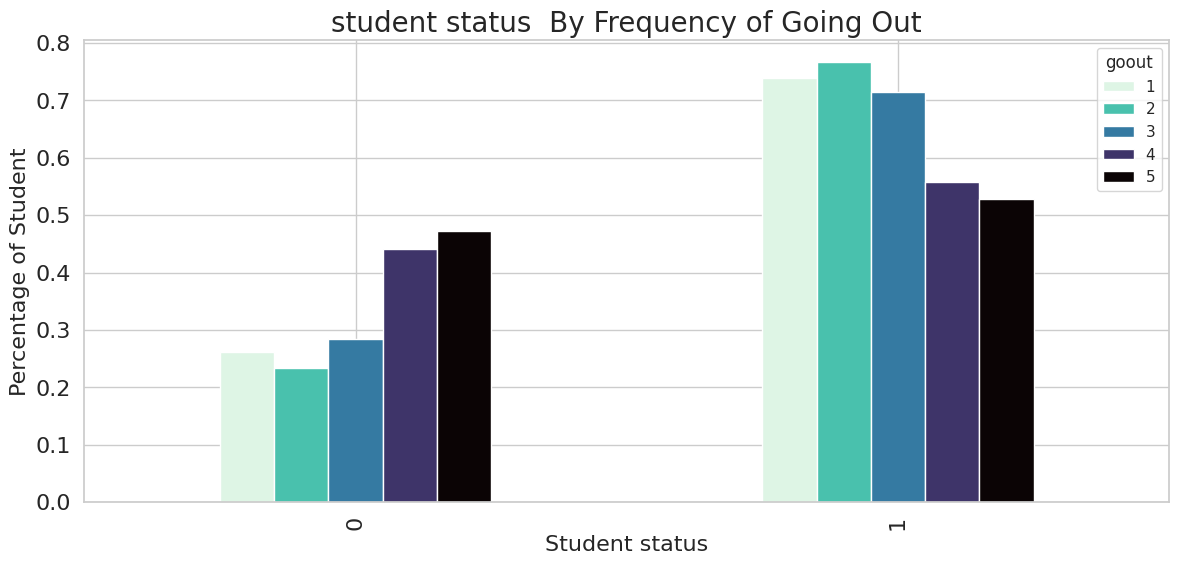

In [67]:
# going out
perc = (lambda col: col/col.sum())
index = [0,1]
out_tab = pd.crosstab(index=df.passed, columns=df.goout)
out_perc = out_tab.apply(perc).reindex(index)
out_perc.plot.bar(colormap="mako_r", fontsize=16, figsize=(14,6))
plt.title('student status  By Frequency of Going Out', fontsize=20)
plt.ylabel('Percentage of Student', fontsize=16)
plt.xlabel('Student status', fontsize=16)



* The more often students go out, the higher the risk of not passing.
* Going out at a low to medium frequency is still acceptable.
* Going out too often is linked to lower academic performance.


Romantic Status

<Figure size 640x480 with 0 Axes>

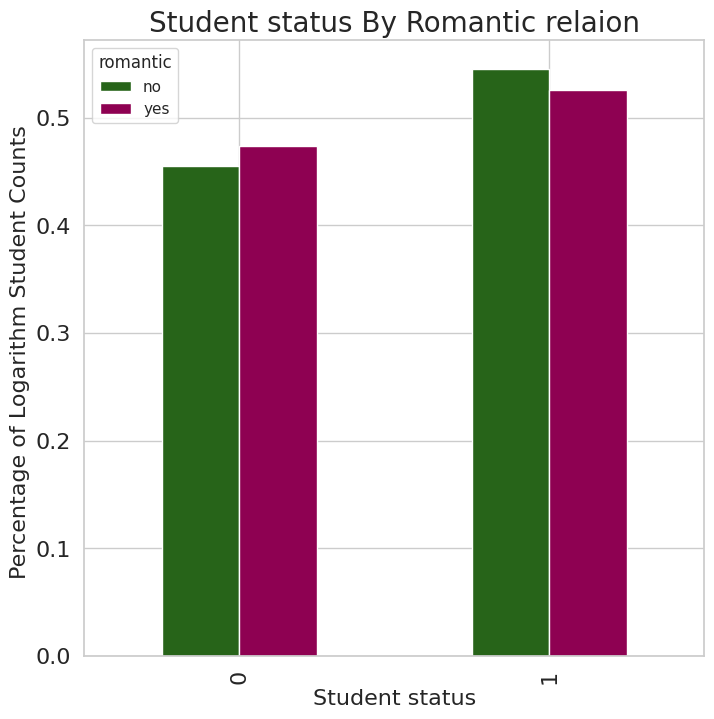

In [68]:
# romantic status
romance_tab1 = pd.crosstab(index=df.passed, columns=df.romantic)
romance_tab = np.log(romance_tab1)
romance_perc = romance_tab.apply(perc).reindex(index)
plt.figure()
romance_perc.plot.bar(colormap="PiYG_r", fontsize=16, figsize=(8,8))
plt.title('Student status By Romantic relaion', fontsize=20)
plt.ylabel('Percentage of Logarithm Student Counts ', fontsize=16)
plt.xlabel('Student status', fontsize=16)
plt.show()
# 0 in romantic mean no romantic relation

Having a romantic relationship has only a small impact on academic performance.

motherjob

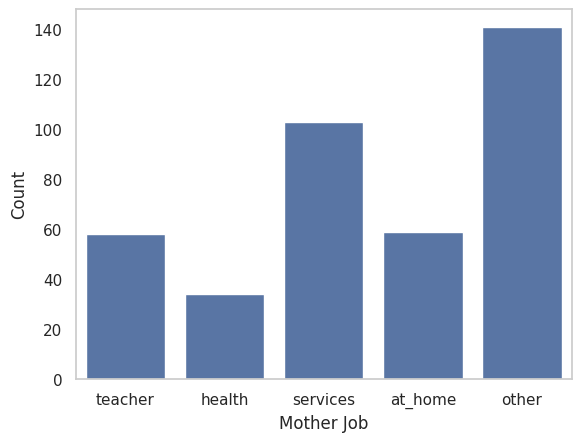

In [70]:
# 1) mother job
# Mjob distribution
f, fx = plt.subplots()
figure = sns.countplot(x = 'Mjob', data=df, order=['teacher','health','services','at_home','other'])
fx = fx.set(ylabel="Count", xlabel="Mother Job")
figure.grid(False)



* Most students have mothers who work in jobs outside the main categories (teacher, health, services).
* Mothers’ jobs are diverse, but most are not in education or health sectors.
* This chart only shows the distribution of mothers’ jobs, not their direct impact on grades or passing.


mother education

/tmp/ipython-input-3018233835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_student_mother_education'] = good.Medu
/tmp/ipython-input-3018233835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_student_mother_education'] = poor.Medu
/tmp/ipython-input-3018233835.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p=sns.kdeplot(good['good_student_mother_education'], s

Text(0.5, 0, 'Mother Education Level')

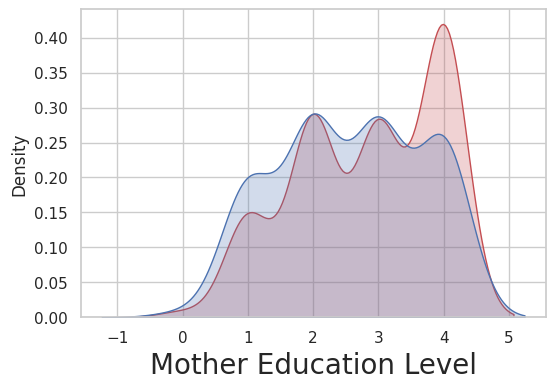

In [71]:
#Mother education:
good = df.loc[df.passed==1]
poor=df.loc[df.passed==0]
good['good_student_mother_education'] = good.Medu
poor['poor_student_mother_education'] = poor.Medu
plt.figure(figsize=(6,4))
p=sns.kdeplot(good['good_student_mother_education'], shade=True, color="r")#good_student in red
p=sns.kdeplot(poor['poor_student_mother_education'], shade=True, color="b")#poor_student in blue
plt.xlabel('Mother Education Level', fontsize=20)

Mother’s education level may influence student performance by affecting the level of learning support and encouragement at home, but the chart shows a trend, not a direct cause.

Student status by deseire to take heigher education:

Text(0, 0.5, 'Percentage of Student')

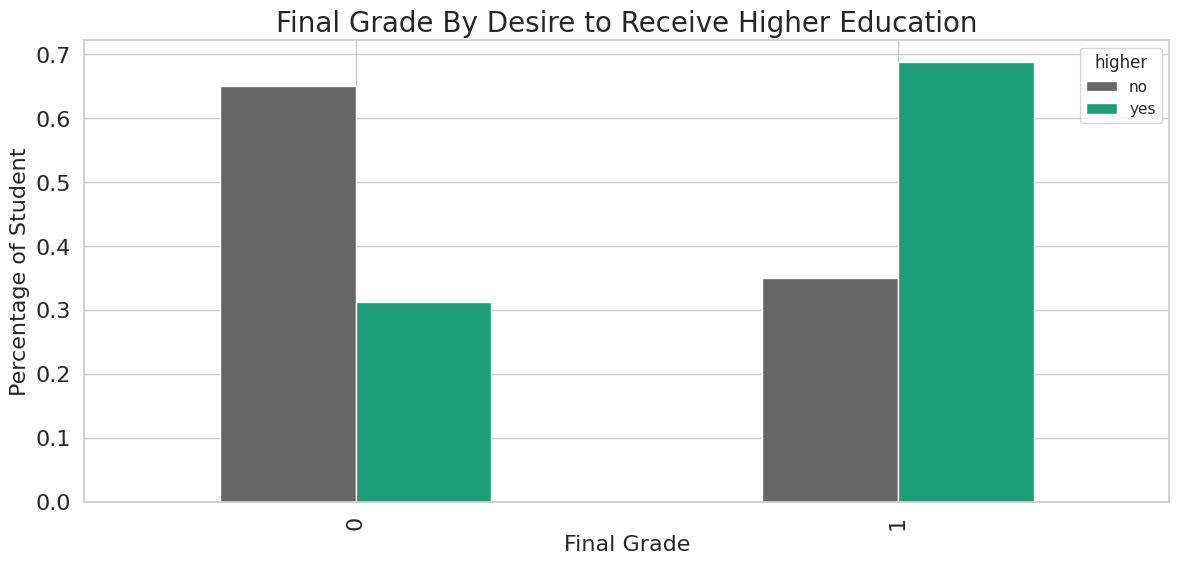

In [72]:
higher_tab = pd.crosstab(index=df.passed, columns=df.higher)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Final Grade By Desire to Receive Higher Education', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Students with plans for higher education usually perform better academically.

age

Text(0, 0.5, 'Percentage of Student')

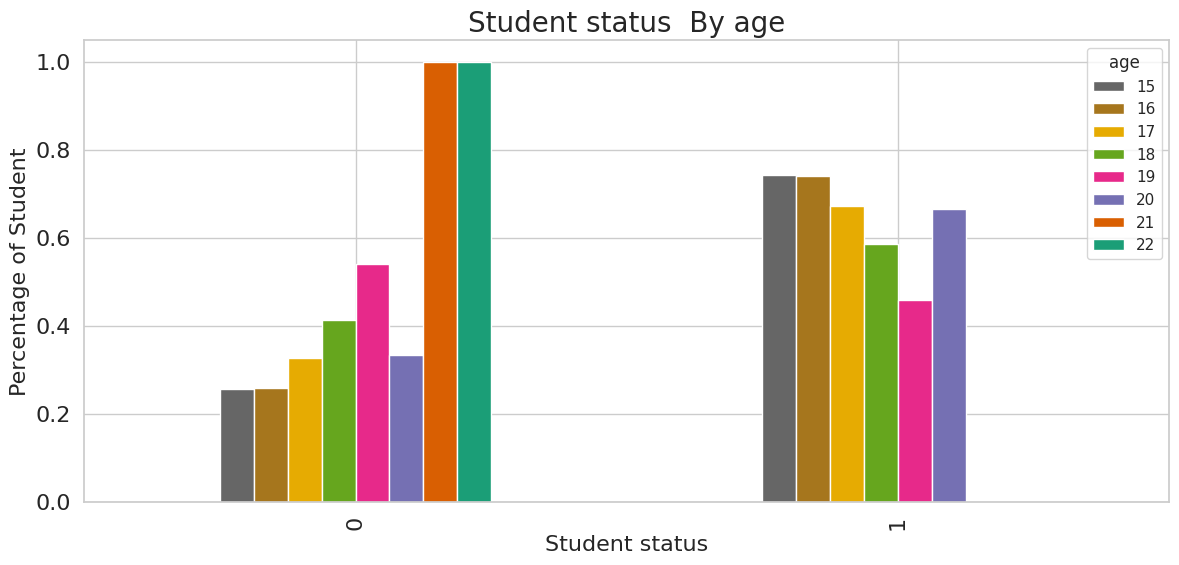

In [74]:
#impact of age
higher_tab = pd.crosstab(index=df.passed, columns=df.age)
higher_perc = higher_tab.apply(perc).reindex(index)
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('Student status  By age', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


Being older is linked to a higher risk of poor academic performance, while younger students tend to perform better.

failures

Text(0, 0.5, 'Percentage of Student')

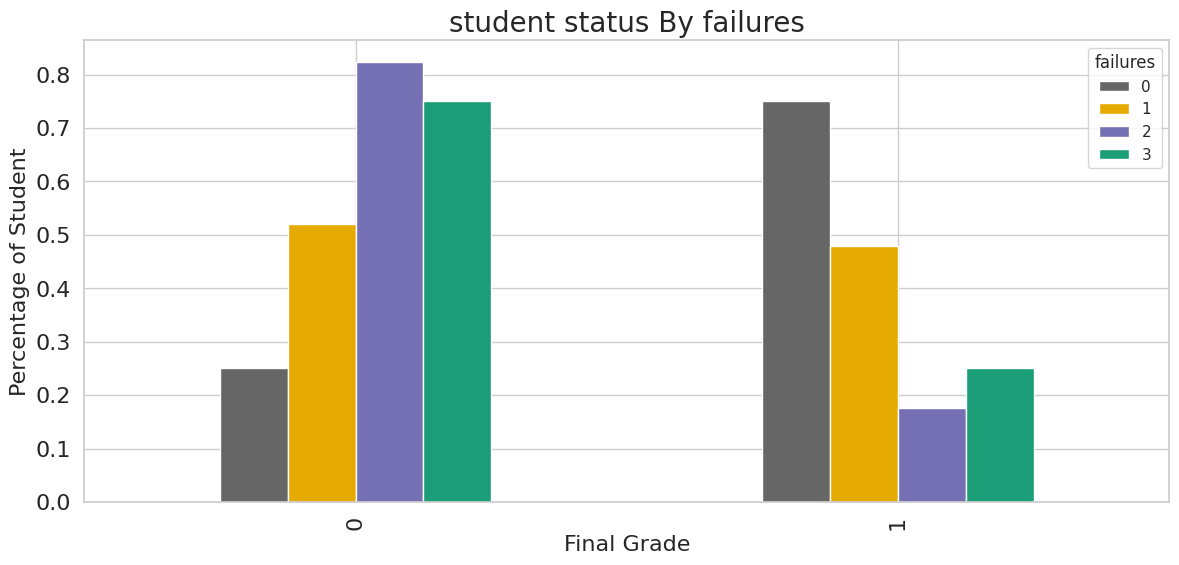

In [75]:
fail_tab = pd.crosstab(index=df.passed, columns=df.failures)
fail_perc = fail_tab.apply(perc).reindex(index)
fail_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By failures', fontsize=20)
plt.xlabel('Final Grade', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

Previous academic failures strongly reduce student performance. Fewer past failures mean a higher chance of passing.

Student status by area


Text(0.5, 1.0, 'Address Distribution')

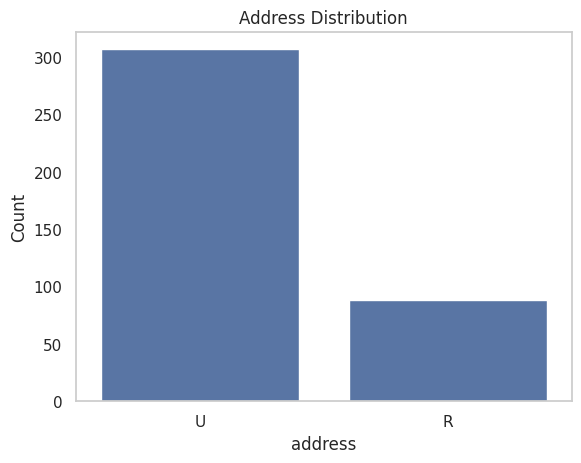

In [77]:
#first let's see the destribution of students who live in urban or rural area
f, fx = plt.subplots()
figure = sns.countplot(x = 'address', data=df, order=['U','R'])
fx = fx.set(ylabel="Count", xlabel="address")
figure.grid(False)
plt.title('Address Distribution')

Text(0.5, 0, 'Student status')

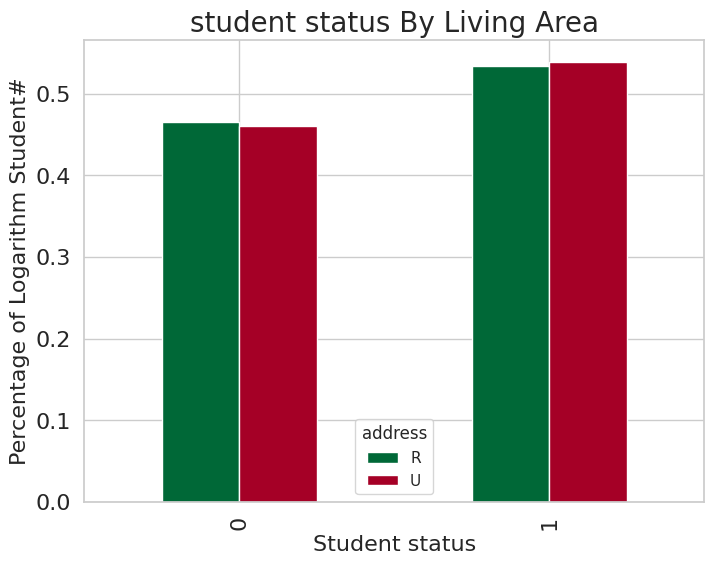

In [78]:
ad_tab1 = pd.crosstab(index=df.passed, columns=df.address)
ad_tab = np.log(ad_tab1)
ad_perc = ad_tab.apply(perc).reindex(index)
ad_perc.plot.bar(colormap="RdYlGn_r", fontsize=16, figsize=(8,6))
plt.title('student status By Living Area', fontsize=20)
plt.ylabel('Percentage of Logarithm Student#', fontsize=16)
plt.xlabel('Student status', fontsize=16)

Area doesn't had an impact on student performance even people with good results live in contry side

alochol consumption

Text(0, 0.5, 'Percentage of Student')

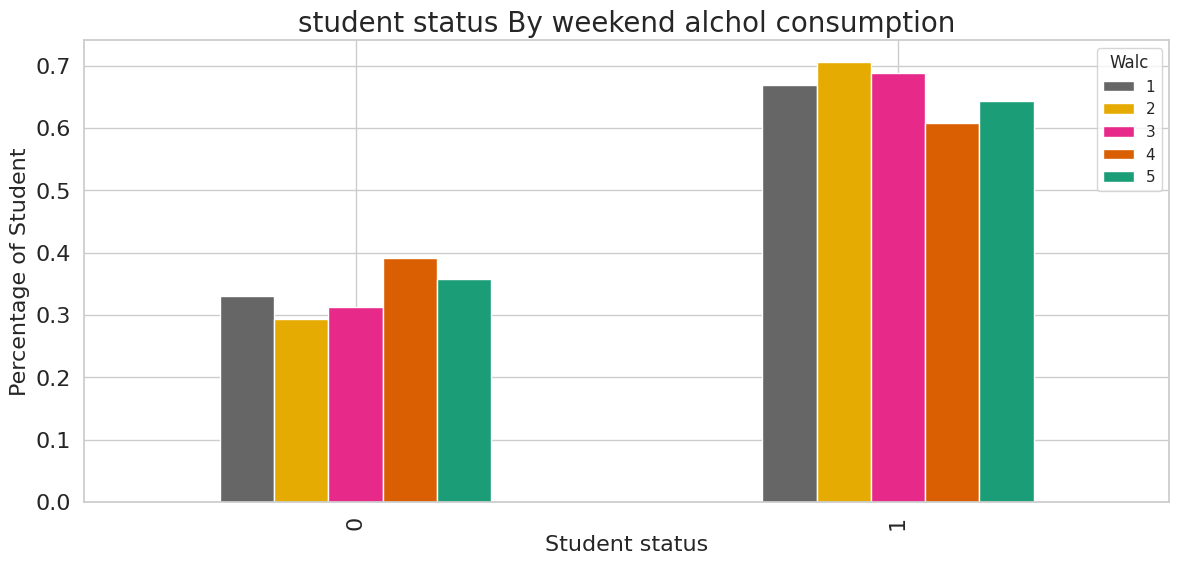

In [79]:
#impact of weekend alcohol consumption in student performance
alc_tab = pd.crosstab(index=df.passed, columns=df.Walc)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By weekend alchol consumption', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)

/tmp/ipython-input-1621555142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good['good_alcohol_usage']=good.Walc
/tmp/ipython-input-1621555142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor['poor_alcohol_usage']=poor.Walc
/tmp/ipython-input-1621555142.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
/tmp/ipython-i

Text(0.5, 0, 'Level of Alcohol Consumption')

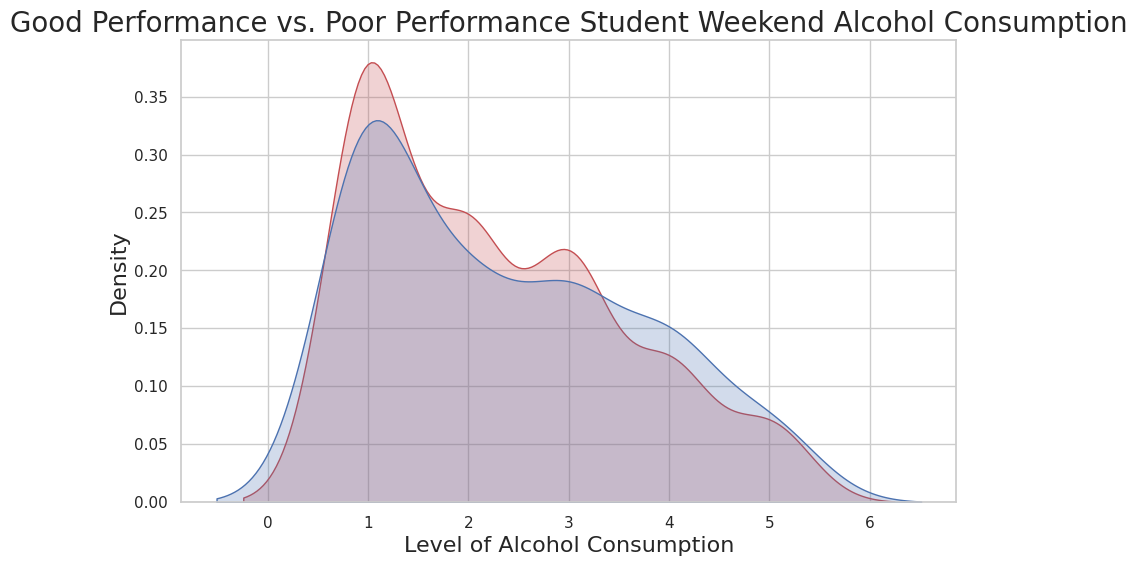

In [80]:
# weekend alcohol consumption
# create good student dataframe
good = df.loc[df.passed == 1]
good['good_alcohol_usage']=good.Walc
# create poor student dataframe
poor = df.loc[df.passed == 0]
poor['poor_alcohol_usage']=poor.Walc
plt.figure(figsize=(10,6))
p1=sns.kdeplot(good['good_alcohol_usage'], shade=True, color="r")
p1=sns.kdeplot(poor['poor_alcohol_usage'], shade=True, color="b")
plt.title('Good Performance vs. Poor Performance Student Weekend Alcohol Consumption', fontsize=20)
plt.ylabel('Density', fontsize=16)
plt.xlabel('Level of Alcohol Consumption', fontsize=16)

For weekely alchool consumption it doesn't have an strong impact on student performance .Even people with low consumption had low grad

internet accesebility

Text(0, 0.5, 'Percentage of Student')

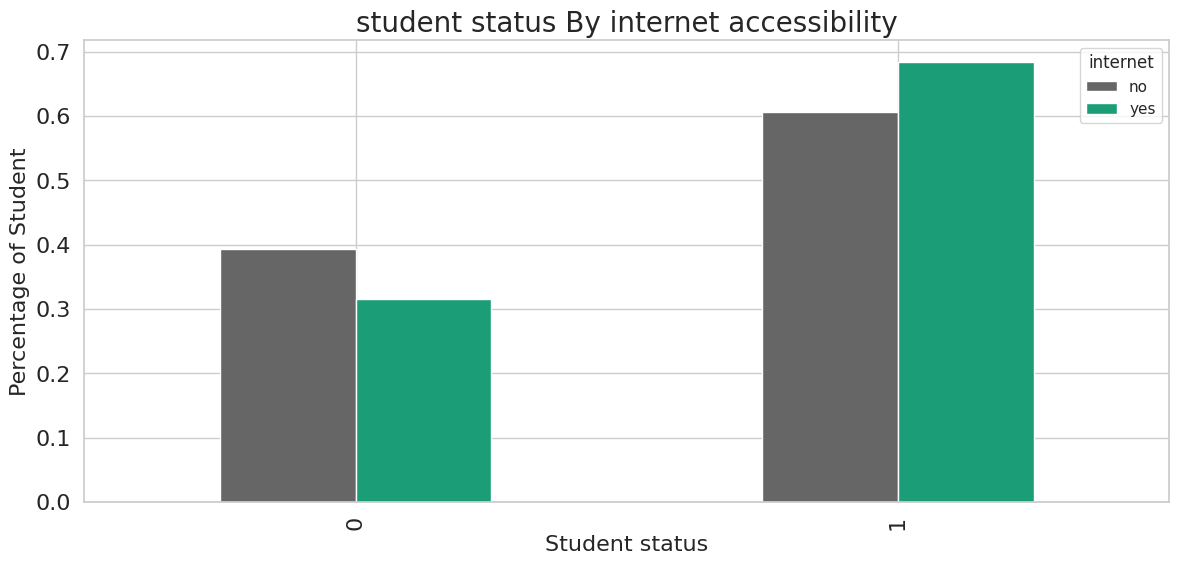

In [81]:
alc_tab = pd.crosstab(index=df.passed, columns=df.internet)
alc_perc = alc_tab.apply(perc).reindex(index)
alc_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By internet accessibility', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


Most of people who passed the exam had the accessibility to internet ,sow we should provide a fair materials's education

study time

Text(0, 0.5, 'Percentage of Student')

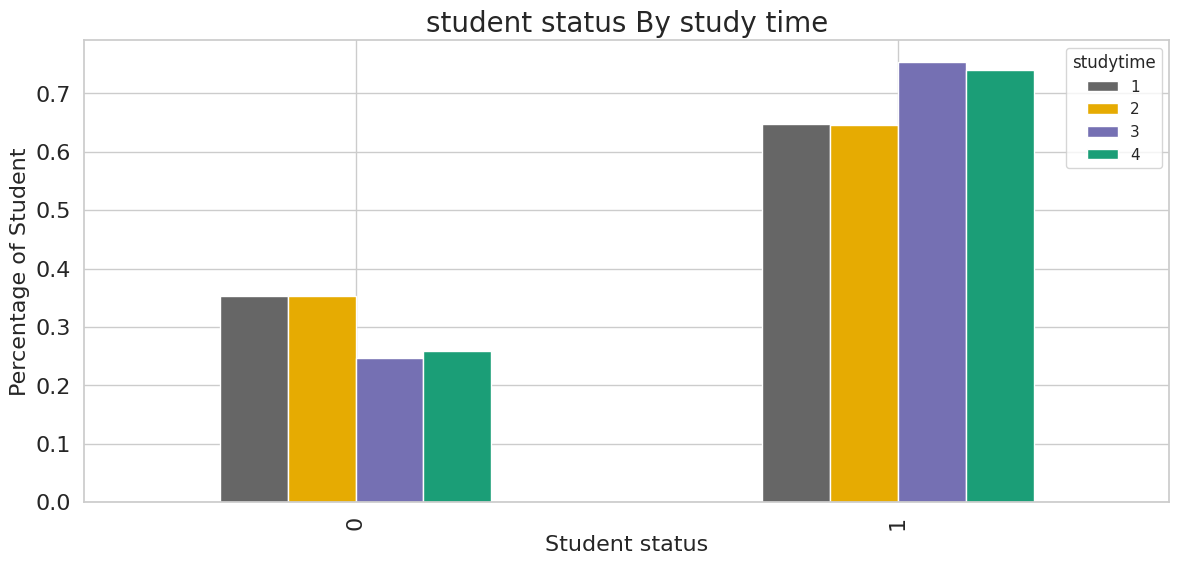

In [82]:
stu_tab = pd.crosstab(index=df.passed, columns=df.studytime)
stu_perc = stu_tab.apply(perc).reindex(index)
stu_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By study time', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


Most of people who passed the exam study 5-10 hours weekely

health

Text(0, 0.5, 'Percentage of Student')

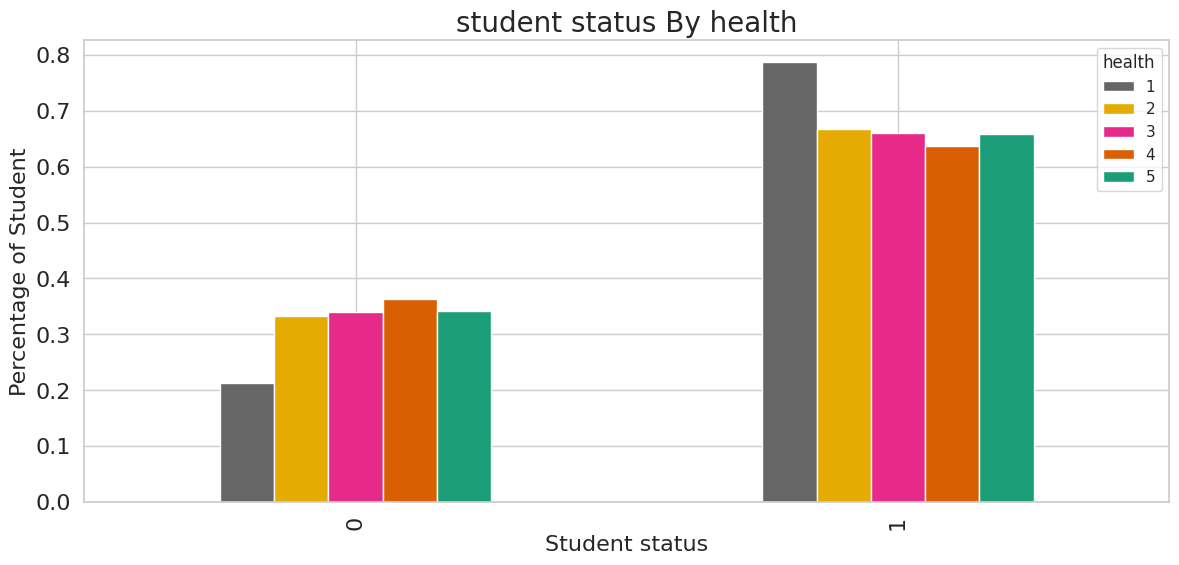

In [83]:
he_tab = pd.crosstab(index=df.passed, columns=df.health)
he_perc = he_tab.apply(perc).reindex(index)
he_perc.plot.bar(colormap="Dark2_r", figsize=(14,6), fontsize=16)
plt.title('student status By health', fontsize=20)
plt.xlabel('Student status', fontsize=16)
plt.ylabel('Percentage of Student', fontsize=16)


most of student who fails the exam don't have a good health

student status baed on Grade 1 ( first period )

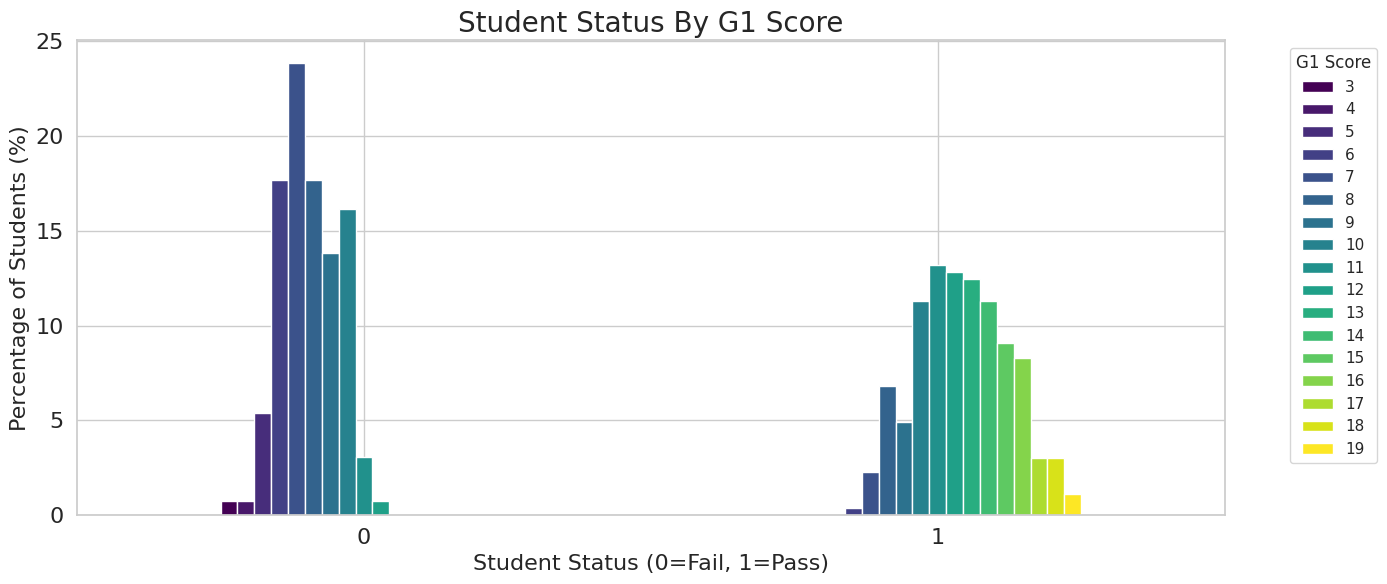

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Fungsi persentase (sesuai logika snippet kamu)
def perc(x):
    return x / x.sum() * 100

# 2. Menyiapkan data
# Pastikan kolom 'passed' sudah ada
df['passed'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)
index = [0, 1] # 0 = Fail, 1 = Pass

# 3. Membuat Crosstab antara status kelulusan (passed) dan nilai G1
g1_tab = pd.crosstab(index=df.passed, columns=df.G1)

# 4. Mengubah angka menjadi persentase dan reindex agar urutan 0 lalu 1
g1_perc = g1_tab.apply(perc, axis=1).reindex(index)

# 5. Plotting (Menggunakan gaya yang sama dengan permintaanmu)
g1_perc.plot.bar(colormap="viridis", figsize=(14,6), fontsize=16)

plt.title('Student Status By G1 Score', fontsize=20)
plt.xlabel('Student Status (0=Fail, 1=Pass)', fontsize=16)
plt.ylabel('Percentage of Students (%)', fontsize=16)
plt.legend(title='G1 Score', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend di luar agar rapi
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

A higher G1 score strongly increases the chance of passing. Early exam performance is a strong indicator of final student success.

student status baed on Grade 2 ( second period )

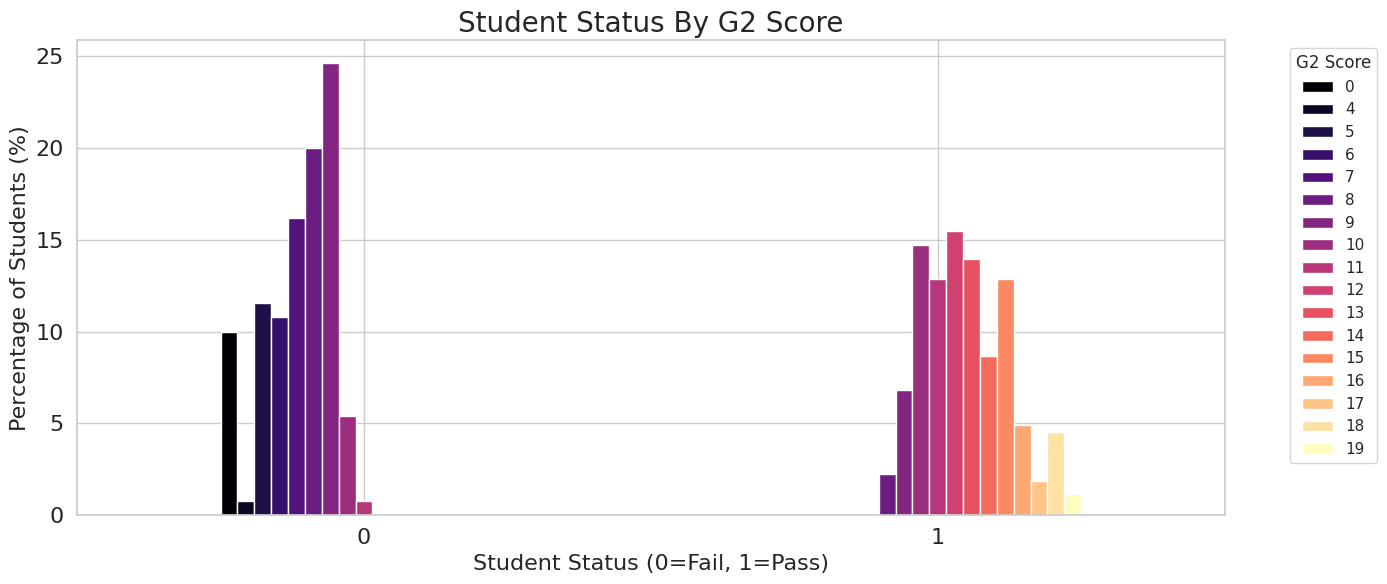

In [85]:
# 1. Menyiapkan data crosstab untuk G2
g2_tab = pd.crosstab(index=df.passed, columns=df.G2)

# 2. Mengubah ke persentase (Normalisasi per baris agar kita bisa bandingkan sebaran nilai)
# Kita gunakan axis=1 agar total persentase di kelompok 'Fail' adalah 100% dan 'Pass' 100%
g2_perc = g2_tab.apply(perc, axis=1).reindex(index)

# 3. Plotting dengan colormap yang berbeda (Magma) agar kontras
g2_perc.plot.bar(colormap="magma", figsize=(14,6), fontsize=16)

plt.title('Student Status By G2 Score', fontsize=20)
plt.xlabel('Student Status (0=Fail, 1=Pass)', fontsize=16)
plt.ylabel('Percentage of Students (%)', fontsize=16)
plt.legend(title='G2 Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

G2 score is a very strong predictor of final student performance. Higher G2 scores mean a much higher chance of passing.

G3

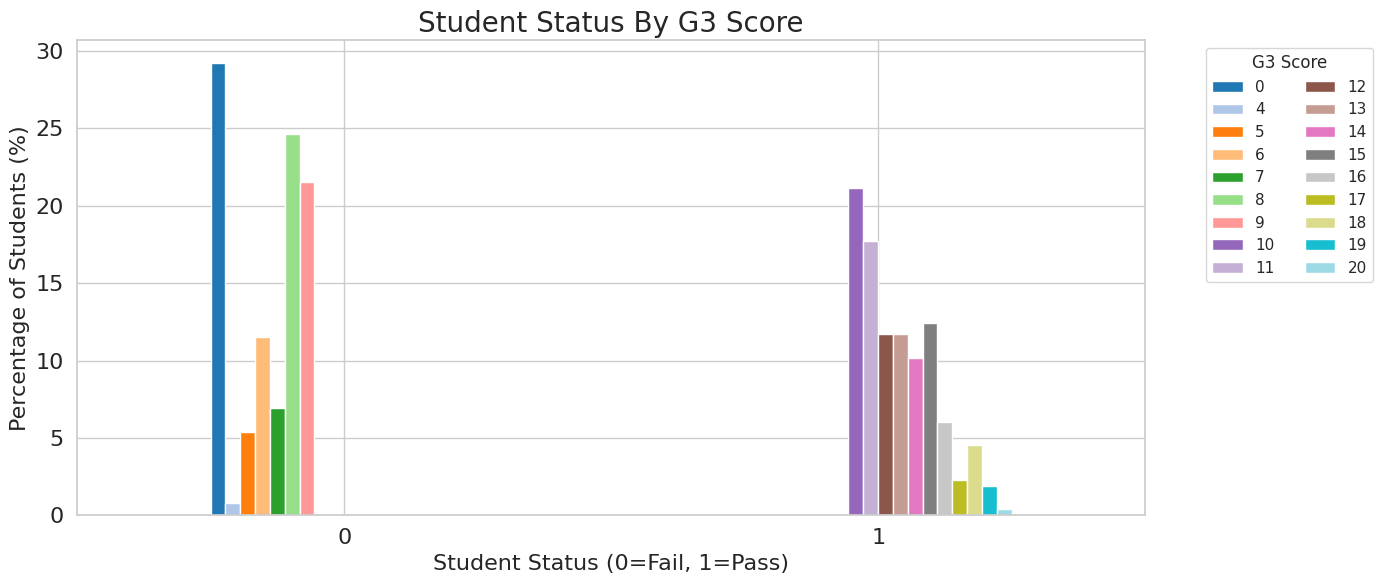

In [86]:
# 1. Menyiapkan data crosstab untuk G3
g3_tab = pd.crosstab(index=df.passed, columns=df.G3)

# 2. Mengubah ke persentase (Normalisasi per baris)
# Kita gunakan axis=1 agar total persentase di kelompok 'Fail' adalah 100% dan 'Pass' 100%
g3_perc = g3_tab.apply(perc, axis=1).reindex(index)

# 3. Plotting dengan colormap tab20 (karena G3 punya banyak variasi nilai)
g3_perc.plot.bar(colormap="tab20", figsize=(14,6), fontsize=16)

plt.title('Student Status By G3 Score', fontsize=20)
plt.xlabel('Student Status (0=Fail, 1=Pass)', fontsize=16)
plt.ylabel('Percentage of Students (%)', fontsize=16)
plt.legend(title='G3 Score', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Feature Selection & Encoding

In [44]:
# Memisahkan fitur (X) dan target (y)
# Kita hapus G3 agar model tidak 'nyontek' nilai akhir
X = df.drop(['G3', 'passed'], axis=1, errors='ignore')
y = df['passed']

# Mengubah data kategorikal menjadi dummy variables (0 dan 1)
X = pd.get_dummies(X, drop_first=True)

print(f"Total fitur setelah encoding: {X.shape[1]}")
X.head()

Total fitur setelah encoding: 41


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False


Split Data & Scalling

In [45]:
# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standarisasi skala data (Sangat penting untuk KNN dan SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data berhasil di-split dan di-scaling.")

Data berhasil di-split dan di-scaling.


Model Implementation & Comparison

Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Model + scaling
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 89.92%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        46
           1       0.92      0.92      0.92        73

    accuracy                           0.90       119
   macro avg       0.89      0.89      0.89       119
weighted avg       0.90      0.90      0.90       119



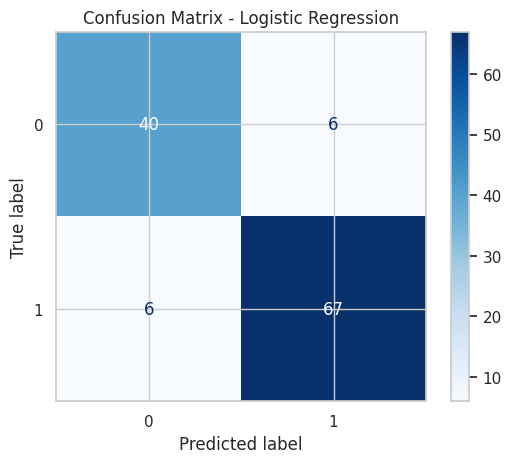

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - Logistic Regression")
plt.show()


SVM (RBF Kernel)

Accuracy: 82.35%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.65      0.74        46
           1       0.81      0.93      0.87        73

    accuracy                           0.82       119
   macro avg       0.83      0.79      0.80       119
weighted avg       0.83      0.82      0.82       119



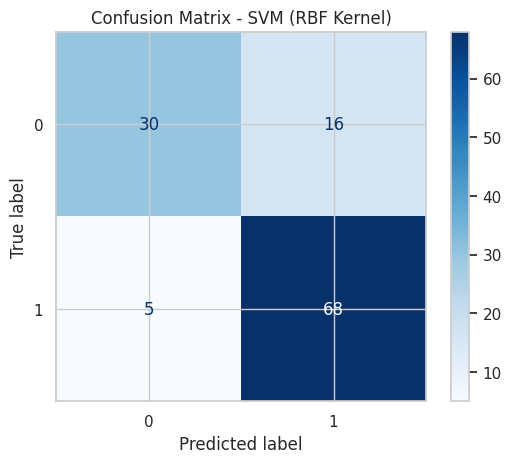

In [94]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model SVM + Scaling
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# Train
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - SVM (RBF Kernel)")
plt.show()


SVM linear kernel

Accuracy: 89.92%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        46
           1       0.92      0.92      0.92        73

    accuracy                           0.90       119
   macro avg       0.89      0.89      0.89       119
weighted avg       0.90      0.90      0.90       119



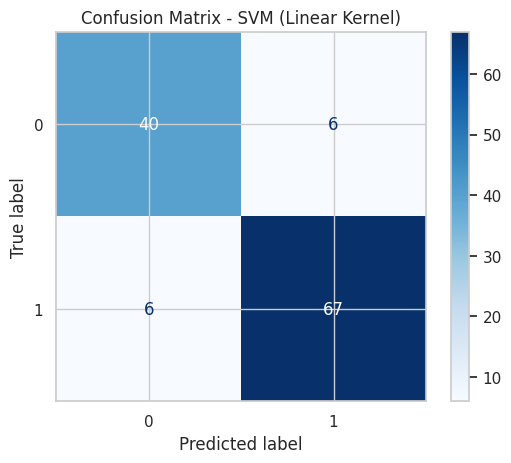

In [95]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model SVM Linear + Scaling
svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

# Train
svm_linear.fit(X_train, y_train)

# Predict
y_pred = svm_linear.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.show()


SVM Polynomial Kernel

Accuracy: 65.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.15      0.25        46
           1       0.65      0.97      0.78        73

    accuracy                           0.66       119
   macro avg       0.71      0.56      0.52       119
weighted avg       0.70      0.66      0.57       119



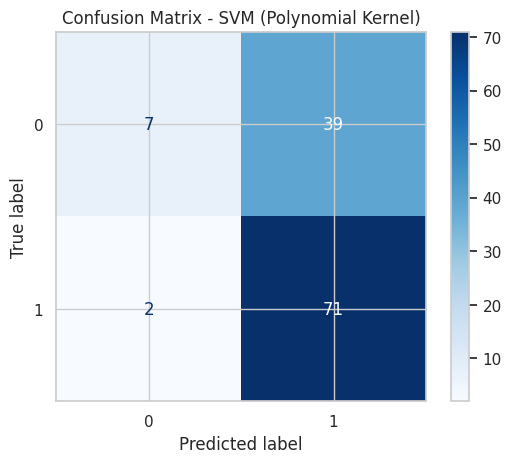

In [96]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model SVM Polynomial + Scaling
svm_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='poly',
        degree=3,        # degree of polynomial (default = 3)
        probability=True,
        random_state=42
    ))
])

# Train
svm_poly.fit(X_train, y_train)

# Predict
y_pred = svm_poly.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - SVM (Polynomial Kernel)")
plt.show()


SVM comparison


=== SVM Comparison (sorted by ROC-AUC) ===
           Model  Accuracy  Precision   Recall       F1  ROC-AUC
      SVM Linear  0.899160   0.917808 0.917808 0.917808 0.973198
         SVM RBF  0.823529   0.809524 0.931507 0.866242 0.931805
SVM Poly (deg=3)  0.655462   0.645455 0.972603 0.775956 0.883264


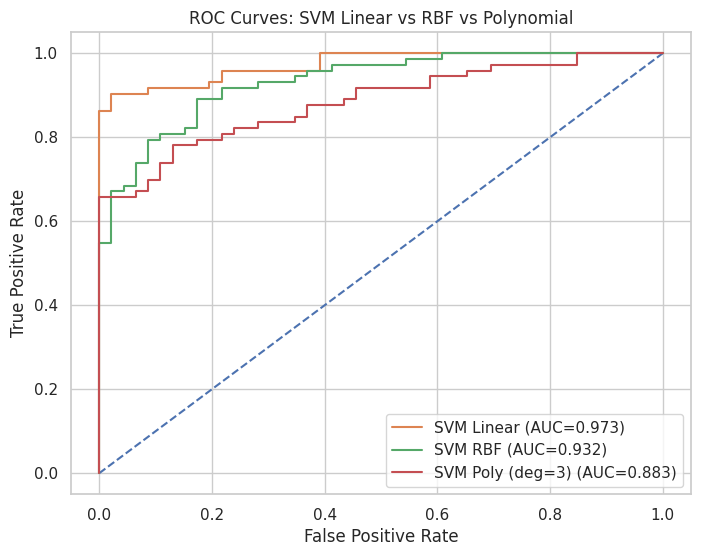

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

# -----------------------------
# 1) Define 3 SVM models (with scaling)
# -----------------------------
models = {
    "SVM Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear", probability=True, random_state=42))
    ]),
    "SVM RBF": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
    "SVM Poly (deg=3)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="poly", degree=3, probability=True, random_state=42))
    ]),
}

# -----------------------------
# 2) Train, evaluate, store metrics + ROC data
# -----------------------------
rows = []
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Probability for ROC (positive class = 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    rows.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": auc
    })

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, auc)

# -----------------------------
# 3) Comparison table
# -----------------------------
results_df = pd.DataFrame(rows).sort_values(by="ROC-AUC", ascending=False)
print("\n=== SVM Comparison (sorted by ROC-AUC) ===")
print(results_df.to_string(index=False))

# -----------------------------
# 4) ROC Curves plot (one figure)
# -----------------------------
plt.figure(figsize=(8, 6))

# Diagonal baseline
plt.plot([0, 1], [0, 1], linestyle="--")

for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: SVM Linear vs RBF vs Polynomial")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


KNN ( Random K)

In [101]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Persiapan Data (Asumsi df sudah ada dari langkah sebelumnya)
# Menggunakan fitur yang sudah dibersihkan/encode
X = df.drop(['G3', 'passed'], axis=1)
X = pd.get_dummies(X) # One-hot encoding untuk fitur kategori
y = df['passed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Memilih nilai K secara acak
random_k = random.randint(1, 20)
print(f"Randomly selected K: {random_k}")

# 3. Menjalankan KNN
knn = KNeighborsClassifier(n_neighbors=random_k)
knn.fit(X_train, y_train)

# 4. Prediksi dan Evaluasi
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with K={random_k}: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Randomly selected K: 3
Accuracy with K=3: 87.34%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        27
           1       0.89      0.92      0.91        52

    accuracy                           0.87        79
   macro avg       0.86      0.85      0.86        79
weighted avg       0.87      0.87      0.87        79



Calculate the best K (elbow method)

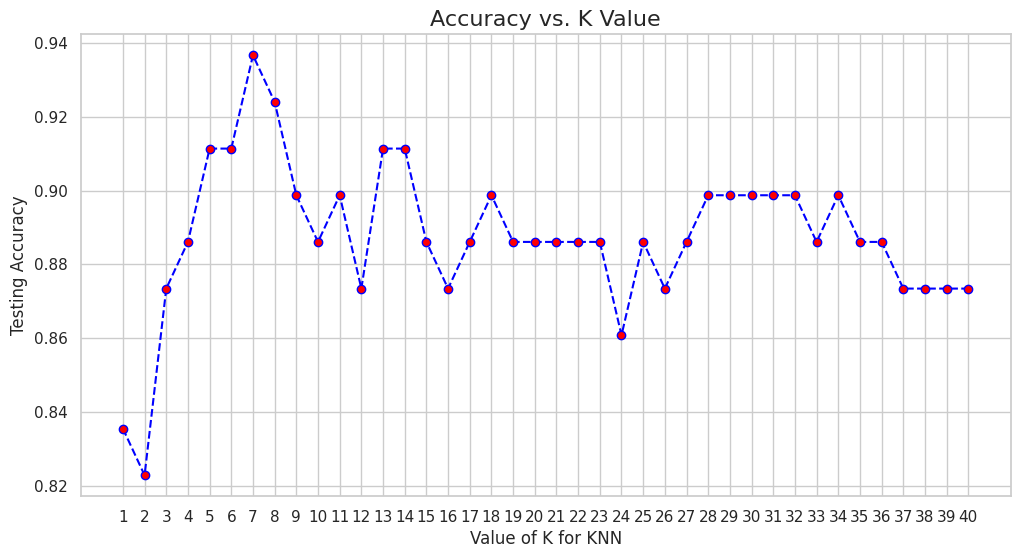

The Best K value is: 7 with an accuracy of 93.67%


In [102]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Inisialisasi list untuk menyimpan hasil akurasi
acc_scores = []
k_range = range(1, 41) # Mencoba nilai K dari 1 sampai 40

# 2. Loop untuk mencoba setiap nilai K
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))

# 3. Mencari K dengan akurasi tertinggi
best_k = k_range[acc_scores.index(max(acc_scores))]
best_acc = max(acc_scores)

# 4. Plot hasilnya
plt.figure(figsize=(12, 6))
plt.plot(k_range, acc_scores, marker='o', linestyle='dashed', color='blue', markerfacecolor='red')
plt.title('Accuracy vs. K Value', fontsize=16)
plt.xlabel('Value of K for KNN', fontsize=12)
plt.ylabel('Testing Accuracy', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

print(f"The Best K value is: {best_k} with an accuracy of {best_acc:.2%}")

k=7

Accuracy with K=7: 93.67%


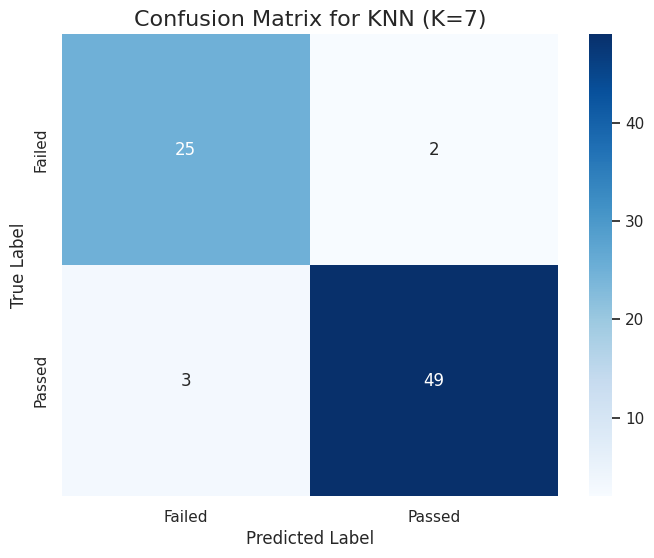


Detailed Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        27
           1       0.96      0.94      0.95        52

    accuracy                           0.94        79
   macro avg       0.93      0.93      0.93        79
weighted avg       0.94      0.94      0.94        79



In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Inisialisasi Model dengan k=7
knn_7 = KNeighborsClassifier(n_neighbors=7)

# 2. Training Model
knn_7.fit(X_train, y_train)

# 3. Prediksi pada data Test
y_pred_7 = knn_7.predict(X_test)

# 4. Evaluasi Akurasi
accuracy = accuracy_score(y_test, y_pred_7)
print(f"Accuracy with K=7: {accuracy:.2%}")

# 5. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_7)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
plt.title('Confusion Matrix for KNN (K=7)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Menampilkan Detail Precision & Recall
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_7))

Random Forest

Random Forest Accuracy: 91.14%


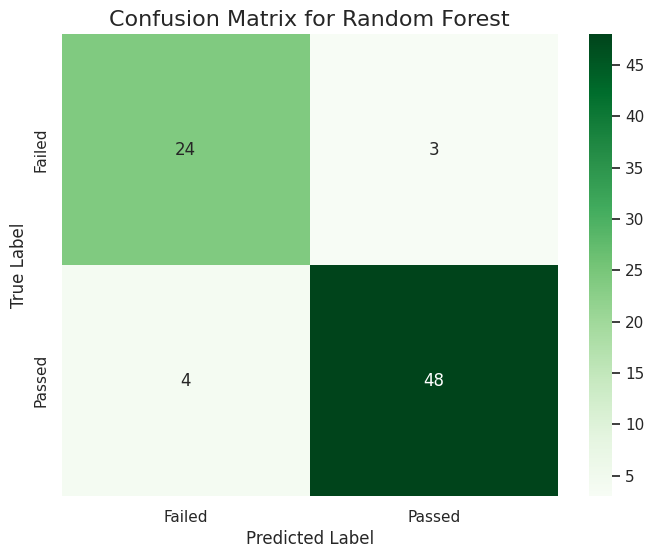


Detailed Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.94      0.92      0.93        52

    accuracy                           0.91        79
   macro avg       0.90      0.91      0.90        79
weighted avg       0.91      0.91      0.91        79



In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Inisialisasi Model Random Forest
# n_estimators=100 berarti kita menggunakan 100 pohon keputusan
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Training Model
rf_model.fit(X_train, y_train)

# 3. Prediksi pada data Test
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluasi Akurasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2%}")

# 5. Visualisasi Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
plt.title('Confusion Matrix for Random Forest', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Menampilkan Detail Precision & Recall
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_rf))

Comparison

/tmp/ipython-input-678834522.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis')


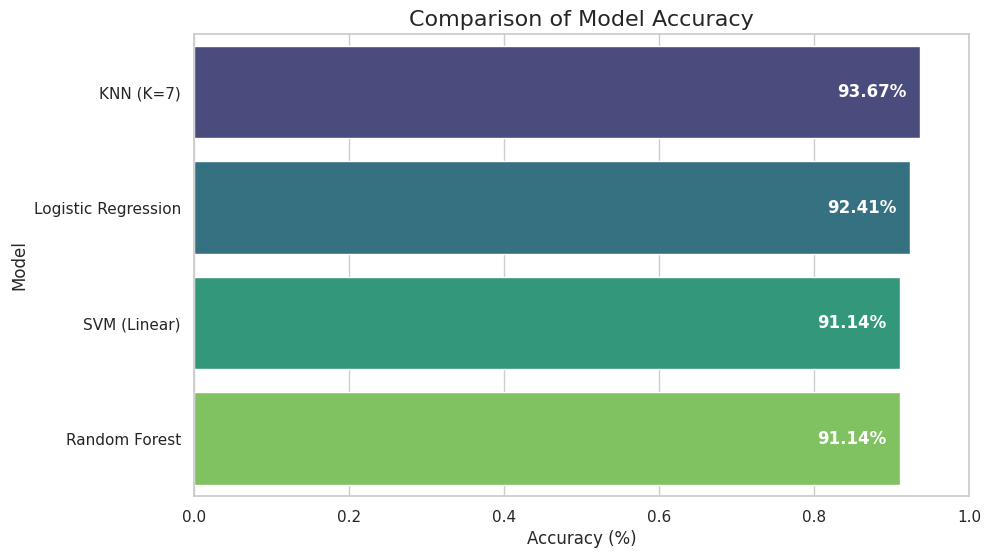

                 Model  Accuracy
0            KNN (K=7)  0.936709
2  Logistic Regression  0.924051
1         SVM (Linear)  0.911392
3        Random Forest  0.911392


In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Inisialisasi Model
models = {
    'KNN (K=7)': KNeighborsClassifier(n_neighbors=7),
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 2. Training dan Hitung Akurasi
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append({'Model': name, 'Accuracy': accuracy})

# 3. Membuat DataFrame untuk hasil
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# 4. Visualisasi Perbandingan
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis')

# Tambahkan angka akurasi di dalam bar
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2%}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha = 'right', va = 'center',
                xytext = (-10, 0),
                textcoords = 'offset points',
                color='white', fontweight='bold')

plt.title('Comparison of Model Accuracy', fontsize=16)
plt.xlabel('Accuracy (%)')
plt.xlim(0, 1.0)
plt.show()

print(df_results)

Conclusion
